In [14]:
# %%capture
! pip install tensorflow-gpu

In [ ]:
# %%capture
! pip install tensorflow==2.2.0-rc2

In this assignment, you will use convolutional neural networks (CNNs) to carry out the task of facial recognition. As shown in class, CNNs are the current state-of-the-art approach for analyzing image-based datasets. More specifically, you will implement a one-shot classification solution. Wikipedia defines one-shot learning as follows: 
*“… an object categorization problem, found mostly in computer vision. Whereas most machine learning based object categorization algorithms require training on hundreds or thousands of samples/images and very large datasets, one-shot learning aims to learn information about object categories from one, or only a few, training samples/images.”*

Our work will be based on the paper Siamese Neural Networks for One-shot Image Recognition . Our goal, like that of the paper, is to successfully execute a one-shot learning task for previously unseen objects. Given two facial images of previously unseen persons, our architecture will have to successfully determine whether they are the same person. 


In [ ]:
import tensorflow as tf
import numpy as np 
from numpy.random import seed
from tensorflow.random import set_seed
SEED = 42
seed(SEED)
set_seed(SEED)

In [ ]:
print('GPU' if tf.test.is_gpu_available() else 'Not GPU. Please change to GPU!')

# Loading Data 

http://vis-www.cs.umass.edu/lfw/index.html

Download the dataset. Note: there are several versions of this dataset, use the version found here - https://talhassner.github.io/home/projects/lfwa/index.html (it’s called LFW-a, and is also used in the DeepFace paper).

In [ ]:
%%capture
# getting the LFW-a 
! gdown https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp 
# getting the recommended training/testing split
! wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
! wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt 
!unzip lfwa.zip

In [0]:
#!rm -rf data
#!rm -rf lfw2
#!rm pairsDevTest.txt
#!rm pairsDevTrain.txt

# Main



In [ ]:
from DataProcessor import DataProcessor
from utils import *
import numpy as np
import shutil
import os
import numpy as np
import pandas as pd
from string import ascii_lowercase, ascii_uppercase
import itertools

In [0]:
prepare_data()

In [0]:
train_paths = DataProcessor(TRAIN_DST_PATH, TRAIN_FILEPATH,False).load_data()
test_paths = DataProcessor(TEST_DST_PATH, TEST_FILEPATH, False).load_data()

## Splitting to train and Val
Needs to explain why the seperation is good.
How to split the data? 
It is often recommended to split the training set into train set and validation set; so we use a 80-20 train-validation ratio.
If we randomly choose a 80-20 seperation ratio we will likely get subjects included in both the training and validation sets, which will cause a problem in the training. 
Therefore, we explore seperating the sets based on the person's name, to guarantee that the sets are independent.
But we can't also do it by person's name since a name can appear in different pairs. 

In [0]:
from prettytable import PrettyTable
train_same = [get_image_name(p[0]) for p in train_paths[:1100]]
train_diff = [get_image_name(p[0]) for p in train_paths[1100:]]

A) first, let's check distribution of each letter/person. 

In [8]:
h_same = get_histogram_of_letters(train_same,1)
h_diff = get_histogram_of_letters(train_diff, 1)

t = PrettyTable([''] + list(h_same.keys()))
t.add_row(['Same'] + list(h_same.values()))
t.add_row(['Different'] + list(h_diff.values()))
print(t)
print()

+-----------+-----+-----+-----+-----+----+----+----+----+----+-----+----+----+-----+----+---+----+---+----+----+----+---+----+----+---+----+---+
|           |  A  |  B  |  C  |  D  | E  | F  | G  | H  | I  |  J  | K  | L  |  M  | N  | O | P  | Q | R  | S  | T  | U | V  | W  | X | Y  | Z |
+-----------+-----+-----+-----+-----+----+----+----+----+----+-----+----+----+-----+----+---+----+---+----+----+----+---+----+----+---+----+---+
|    Same   | 101 |  59 |  80 |  58 | 45 | 20 | 50 | 42 | 9  | 145 | 29 | 41 | 102 | 25 | 4 | 46 | 7 | 74 | 62 | 45 | 1 | 16 | 17 | 3 | 13 | 6 |
| Different | 144 | 121 | 114 | 103 | 64 | 31 | 62 | 47 | 16 | 151 | 34 | 40 |  63 | 22 | 1 | 34 | 2 | 20 | 21 | 8  | 0 | 1  | 1  | 0 | 0  | 0 |
+-----------+-----+-----+-----+-----+----+----+----+----+----+-----+----+----+-----+----+---+----+---+----+----+----+---+----+----+---+----+---+



so, In order to get 80% train-validation ratio, we need to explore which letters to choose in order to get approximately 80% train-validation ratio for each class (Same/Different). I'll use this algorithm of subset sum for each of the different classes (Same/Different) to find a subset of size (3) with total sum of $$ p_{validation} * {totalsize} = 0.2*1100 = 220 $$ with ${\delta}$  of 5. I will do it also for the total and see the intersection of the indexes.


In [0]:

arr_same = list(h_same.values())
res_same =  [tuple(x) for x in subset_sum(arr_same, 3, 220, 5, [])]

arr_diff = list(h_same.values())
res_diff = [tuple(x) for x in subset_sum(arr_same, 3, 220, 5, [])]


h_total = h_same.copy()
for key in h_diff.keys():
  h_total[key] += h_diff[key]

arr_total = list(h_same.values())
res_total = [tuple(x) for x in subset_sum(arr_same, 3, 440, 5, [])]

* One of the solution for the problem this algorithm will gives us the sum of the indexes of J,K,L.

Let's see the details if I choose J,K,L as letters, which means that all the images of the people starts with those letters will be considered as part of validation set:

In [10]:
letters_selected_same = h_same['J'] + h_same['K'] + h_same['L']
letters_selected_different = h_diff['J'] + h_diff['K'] + h_diff['L']

t = PrettyTable(['', 'Total Size', 'Chosen Letters', 'Chosen Letters Size', 'Percentage'])
t.add_row(['Same', sum(h_same.values()), 'J,K,L', letters_selected_same, f'{letters_selected_same/len(train_same)*100:.2f}%'])
t.add_row(['Different', sum(h_diff.values()), 'J,K,L', letters_selected_different, f'{letters_selected_different/len(train_diff)*100:.2f}%'])
t.add_row(['All', sum(h_same.values()) + sum(h_diff.values()), 'A-Z', letters_selected_same + letters_selected_different,  f'{(letters_selected_same + letters_selected_different)/(len(train_same) + len(train_diff))*100:.2f}%'])
print(t)

+-----------+------------+----------------+---------------------+------------+
|           | Total Size | Chosen Letters | Chosen Letters Size | Percentage |
+-----------+------------+----------------+---------------------+------------+
|    Same   |    1100    |     J,K,L      |         215         |   19.55%   |
| Different |    1100    |     J,K,L      |         225         |   20.45%   |
|    All    |    2200    |      A-Z       |         440         |   20.00%   |
+-----------+------------+----------------+---------------------+------------+


Looks Good! Let's split now:


In [11]:
train_same_paths, val_same_paths = split_data_by_letters(train_paths[:1100], letters='JKL')
train_diff_paths, val_diff_paths = split_data_by_letters(train_paths[1100:], letters='JKL') 

train_total_split = train_same_paths + train_diff_paths
val_total_split = val_same_paths + val_diff_paths

t = PrettyTable(['', 'Size', 'Percentage'])
t.add_row(['Train Same', f'{len(train_same_paths)}/{len(train_paths)}', f'{len(train_same_paths)/len(train_paths)*100:.2f}%'])
t.add_row(['Train Different', f'{len(train_diff_paths)}/{len(train_paths)}', f'{len(train_diff_paths)/len(train_paths)*100:.2f}%'])
t.add_row(['Train', f'{len(train_total_split)}/{len(train_paths)}', f'{len(train_total_split)/len(train_paths)*100:.2f}%'])
t.add_row(['', '', ''])
t.add_row(['Validation Same', f'{len(val_same_paths)}/{len(train_paths)}', f'{len(val_same_paths)/len(train_paths)*100:.2f}%'])
t.add_row(['Validation Different', f'{len(val_diff_paths)}/{len(train_paths)}', f'{len(val_diff_paths)/len(train_paths)*100:.2f}%'])
t.add_row(['Validation', f'{len(val_total_split)}/{len(train_paths)}', f'{len(val_total_split)/len(train_paths)*100:.2f}%'])
print(t)

+----------------------+-----------+------------+
|                      |    Size   | Percentage |
+----------------------+-----------+------------+
|      Train Same      |  885/2200 |   40.23%   |
|   Train Different    |  875/2200 |   39.77%   |
|        Train         | 1760/2200 |   80.00%   |
|                      |           |            |
|   Validation Same    |  215/2200 |   9.77%    |
| Validation Different |  225/2200 |   10.23%   |
|      Validation      |  440/2200 |   20.00%   |
+----------------------+-----------+------------+


## Create dataset for tensorflow

<ParallelMapDataset shapes: (None, None, 1), types: tf.uint8>


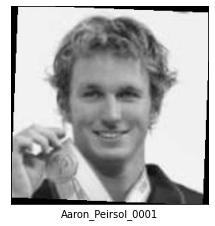

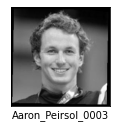

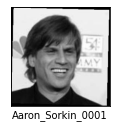

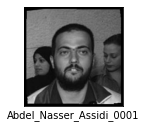

Same
Same
Same
Same
Same
Same
Same
Same
Same
Same


In [12]:
from utils import create_tensor_dataset, get_image_name
import numpy as np
import matplotlib.pyplot as plt

labels_names = ['Different', 'Same']

left_train_paths = [ p[0] for p in train_paths]
image_data_tensor = create_tensor_dataset(img_paths=left_train_paths)
print(image_data_tensor)

plt.figure(figsize=(8,8))
for n, image in enumerate(image_data_tensor.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=255)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(get_image_name(left_train_paths[n]))
  plt.show()
  
labels = [ p[2] for p in train_paths ]
label_dataset_tensor = create_tensor_dataset(labels=labels)
for l in label_dataset_tensor.take(10):
  print(labels_names[int(l.numpy())])

## Run Model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 125, 125, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 125, 125, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 256)          11419072    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256)          0           sequential_1[1][0]         

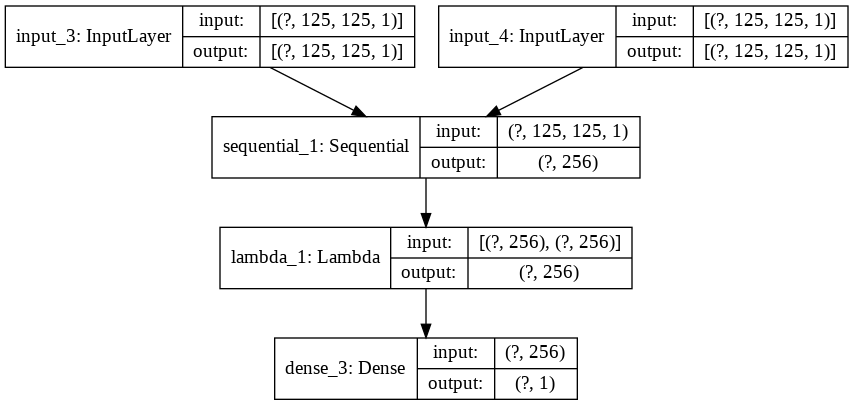

In [15]:
# Print model information 
from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY
from tensorflow.keras.utils import plot_model
from Model import SiameseModel


siamese_model = SiameseModel(
    filter_size=64,
    input_shape=[125,125,1],
    units=4*64 #filters*64
    #input_shape = (256,256,1)
)

siamese_model.model.summary()
plot_model(siamese_model.model, 'siamese-network.png', show_shapes=True)

In [16]:
 _, acc = siamese_model.fit(train_paths_labels=train_total_split,
                            val_paths_labels=val_total_split,
                            epochs=30,
                            _resize=[125,125],
                            verbose=False,
                            prefix='')
 print(acc)

Steps per epoch: 13
Validation Steps:3


AssertionError: ignored

In [0]:
# install tensorboard - I used this guide: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/


#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

# Load the TensorBoard notebook extension
# %load_ext tensorboard.notebook
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./fit_logs/

LOG_DIR = 'fit_logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')


## Hyper Parameters

In [0]:
from utils import distance_acc
from tensorboard.plugins.hparams import api as hyper
from tensorflow.keras.metrics import Precision, Recall

UNITS_PARAM = hyper.HParam('units', hyper.Discrete([1024,2048]))

NUM_FILTERS_PARAM = hyper.HParam('filter_size', hyper.Discrete([4,8,16,32,64]))

BATCH_SIZE_PARAM = hyper.HParam('batch_size', hyper.Discrete([32,64,128,256]))

OPTIMIZER_PARAM = hyper.HParam('optimizer', hyper.Discrete(['adam', 'sgd', 'rms']))

LR_PARAM=hyper.HParam('lr', hyper.Discrete([1e-4, 1e-3, 1e-2]))

METRIC_ACCURACY = 'accuracy'
#METRIC_ACCURACY = distance_acc

with tf.summary.create_file_writer('fit_logs/hparam_tuning').as_default():
  hyper.hparams_config(
    hparams=[
        UNITS_PARAM, 
        NUM_FILTERS_PARAM, 
        BATCH_SIZE_PARAM, 
        OPTIMIZER_PARAM,
        LR_PARAM
    ],
    metrics=[
        hyper.Metric(METRIC_ACCURACY, display_name='Accuracy'), 
    ],
  )



In [0]:
from Model import initialize_weights
from utils import abs_distance


def run_hyper_params(dir, hparams, prefix, table=None, eval_table=None,
                     verbose=True, kernel_initializer=initialize_weights, 
                distance=abs_distance, distance_output_shape=None,
                 loss='binary_crossentropy', metrics=['accuracy'],
                epochs=100):
  
  with tf.summary.create_file_writer(dir).as_default():    
    hyper.hparams(hparams)  # record the values used in this trial
    siamese_model = SiameseModel(filter_size=hparams[NUM_FILTERS_PARAM],
                                 units=hparams[UNITS_PARAM],
                                 distance=distance,
                                 distance_output_shape=distance_output_shape,
                                 loss=loss,
                                 metrics=metrics,
                                 optimizer=hparams[OPTIMIZER_PARAM],
                                 lr=hparams[LR_PARAM])
    _, acc = siamese_model.fit_evaluate(train_paths_labels=train_total_split,
                            val_paths_labels=val_total_split,
                            test_paths_labels = test_paths,
                            fit_table=table,
                            eval_table=eval_table,
                            _resize = [125,125],
                            batch_size=hparams[BATCH_SIZE_PARAM], 
                            epochs=epochs,
                            verbose=verbose,
                            prefix=prefix, 
                            callbacks=[hyper.KerasCallback(dir, hparams)])
    tf.summary.scalar(METRIC_ACCURACY, acc, step=1)

In [0]:
session_num = 1


model_table = PrettyTable(['Start_Runtime', 'Name', 'Resize', 'Epochs', 'Units', 'Filters', 'Batch Size', 'Optimizer', 'LR'])
model_table.set_style(MSWORD_FRIENDLY)
eval_table = PrettyTable([
    'Name',
    'Train_Time', 'Test_Loss', 'Test_Accuracy', 
    'Val_Loss', 'Val_Accuracy'
])
eval_table.set_style(MSWORD_FRIENDLY)


for num_units in UNITS_PARAM.domain.values:
  for filters in NUM_FILTERS_PARAM.domain.values:
    for optimizer in OPTIMIZER_PARAM.domain.values:
      for lr in LR_PARAM.domain.values:
        for batch_size in BATCH_SIZE_PARAM.domain.values:
#           for dropout_rate in HP_DROPOUT.domain.values:
          hparams = {
              UNITS_PARAM: num_units,
              NUM_FILTERS_PARAM: filters,
              BATCH_SIZE_PARAM: batch_size,
              OPTIMIZER_PARAM: optimizer,
              LR_PARAM: lr
          }
          run_title = f'Run_{session_num}'
          print(f'--- Starting Running: {run_title} --- ')
          print({h.name: hparams[h] for h in hparams})
          run_hyper_params(
              dir=f'fit_logs/hparam_tuning/{run_title}',
              hparams=hparams,
              prefix=f'hparam_{session_num}_all',
              table=model_table,
              eval_table = eval_table
          )
          session_num += 1

In [0]:
%tensorboard --logdir fit_logs/hparam_tuning/

In [0]:
!rm fit_logs/hparam_tuning/Run_1

In [0]:
from utils import create_tensor_dataset
import time
import datetime
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorboard.plugins.hparams import api as hyper

def model_fit(    
    train_paths_labels,
    val_paths_labels,
    table=None,
    _resize=[250, 250],
    norm=255.0,
    batch_size=128,
    filter_size=4,
    lr=3e-4,
    epochs=30,
    verbose=1, 
    pretrained_weights=None,
    model_path=None,
    distance=abs_distance,
    distance_output_shape=None,
    activation_predict='sigmoid',
    train_data=None,
    validation_data=None,
    callbacks=None,
    steps_per_epoch=None,
    validation_steps=None,
    prefix='',
#     shuffle=True,
    hparam=None,
    patience=3,
    units=4*64,
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='Precision'), Recall(name='Recall')],
    tensorboard_hist_freq=1,
):  
  start_time = time.time()
  input_shape = (_resize[0], _resize[1], 1)
  start_runtime = datetime.datetime.now().strftime('%m%d-%H%M%S')
  log_name = f'{prefix}_{start_runtime}_shape{_resize[0]}_batch{batch_size}_epochs{epochs}_lr{lr}'
  log_paths = f'fit_logs/{log_name}'


  if optimizer is None or optimizer == 'adam':
    optimizer = Adam(lr=lr)
  elif optimizer == 'sgd':
    optimizer = SGD(lr=lr)
  elif optimizer == 'rms':
    optimizer = RMSprop(lr=lr)


  if table is not None:
      # table = PrettyTable['Start_Runtime', 'Name', 'Resize', 'Epochs', 'Units', 'Num_Filters', 'Optimizer', 'LR', 'Batch Size'])
      if hparam is not None:
          table.add_row(
              [start_runtime, log_name, _resize[0], epochs] + [hparam[param] for param in hparam])
      else:
          table.add_row(
              [start_runtime, log_name, _resize[0], epochs, units, filter_size,
                batch_size, optimizer, lr])
      print(table)

  if steps_per_epoch is None:
      steps_per_epoch = len(train_paths_labels) // batch_size
  if validation_steps is None:
      validation_steps = len(val_paths_labels) // batch_size

  print(f'Steps per epoch: {steps_per_epoch}')
  print(f'Validation Steps:{validation_steps}')

  train_data = init_tensor_data(train_data, images_labels_path=train_paths_labels, norm=norm, _resize=_resize,
                                batch_size=batch_size, verbose=verbose)
  validation_data = init_tensor_data(validation_data, images_labels_path=val_paths_labels, norm=norm,
                                      _resize=_resize, batch_size=batch_size, verbose=verbose)
  

  siameseModel = SiameseModel(
        input_shape=input_shape, 
        filter_size=filter_size, 
        units=units,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        pretrained_weights=pretrained_weights,
        model_path=model_path,
        distance=distance,
        distance_output_shape=distance_output_shape,
        activation_predict=activation_predict,
    ) 
  if pretrained_weights is None:
      if callbacks is None:
          callbacks = []

      tb_callback = TensorBoard(
          log_dir=log_paths,
          histogram_freq=tensorboard_hist_freq,
      )
      early_stop = EarlyStopping(patience=patience, verbose=verbose)
      mc = ModelCheckpoint(f'{log_name}.h5', verbose=0, save_best_only=True, save_weights_only=True)

      callbacks.append(tb_callback)
      callbacks.append(early_stop)
      callbacks.append(mc)

      if hparam is not None:
          callbacks.append(hyper.KerasCallback(log_paths, hparam))

      siameseModel.model.fit(train_data, epochs=epochs, verbose=verbose, callbacks=callbacks,
                      validation_data=validation_data, steps_per_epoch=steps_per_epoch,
                      validation_steps=validation_steps)

  train_time = time.time() - start_time
  print(f'############## {train_time:.2f} seconds! ##############')
  return table, train_time